In [1]:
#Import the required modules for data generation
import numpy as np

#Import the required modules for plot creation:
import matplotlib.pyplot as plt
%matplotlib inline

#Import the required modules for DataFrame creation:
import pandas as pd

#Import the required modules for TimeSeries data generation:
import statsmodels.api as sm
#Import the required modules for test statistic calculation:
import statsmodels.stats as sm_stat
#Import the required modules for model estimation:
import statsmodels.tsa as smt
#Import the required modules for optimization:
import scipy.optimize as optimize

#We also need additional data:
import statsmodels.formula.api as smf

In [2]:
cpi_qq = pd.read_csv('data/cpi_qq.csv', parse_dates=['Date'], dayfirst=True, date_format='%Y-%m-%d', index_col='Date', sep=',')
gdp_qq = pd.read_csv('data/ggdp_qq.csv', parse_dates=['Date'], dayfirst=True, date_format='%Y-%m-%d', index_col='Date', sep=',')
data = pd.concat([np.log(cpi_qq.CPI_QQ / 100), gdp_qq], axis=1)[1:]
data.head()

,CPI_QQ,GGDP_RB_SA
Date,,
2016-10-01,0.016884,-0.000238
2017-01-01,0.005526,0.000629
2017-04-01,0.018813,0.012304
2017-07-01,0.005683,0.017064
2017-10-01,0.012632,0.014169


In [109]:
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n) 

    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

In [422]:
exog = data.CPI_QQ
endog = data.GGDP_RB_SA
lags = 3
lags_degree = 3

In [408]:
X = np.zeros((exog.shape[0], lags+1))
for i in range(lags + 1):
    X[:,i] = lag(exog, i).fillna(0)
X = sm.add_constant(X)
model = sm.OLS(endog.values, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     1.500
Date:                Thu, 16 May 2024   Prob (F-statistic):              0.234
Time:                        21:23:57   Log-Likelihood:                 62.211
No. Observations:                  29   AIC:                            -114.4
Df Residuals:                      24   BIC:                            -107.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0131      0.012      1.140      0.2

In [409]:
dl_predicts = model.predict(exog=pd.DataFrame(X).set_index(exog.index))

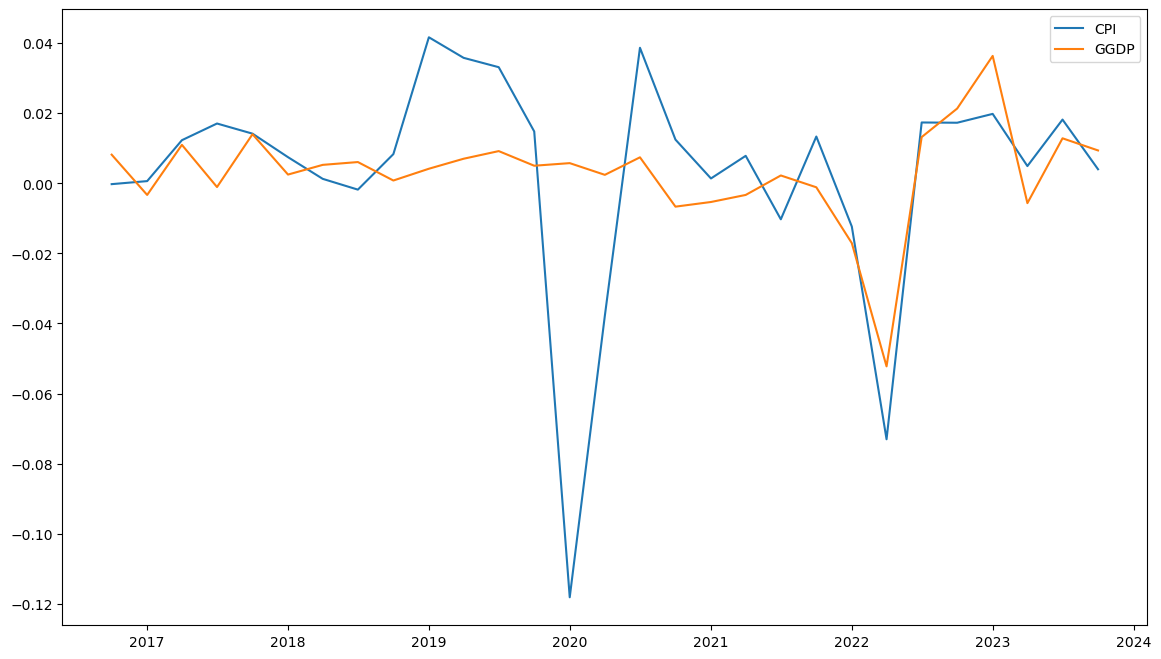

In [410]:
plt.figure(figsize=(14, 8))
plt.plot(endog)
plt.plot(dl_predicts)
plt.legend(('CPI', 'GGDP'))
None

In [423]:
X = np.zeros((exog.shape[0], lags_degree+1))
for i in range(lags_degree + 1):
    for j in range(lags + 1):
        X[:,i] += j**i * lag(exog, j).fillna(0)
X = sm.add_constant(X)
model = sm.OLS(endog.values, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     1.500
Date:                Thu, 16 May 2024   Prob (F-statistic):              0.234
Time:                        21:47:11   Log-Likelihood:                 62.211
No. Observations:                  29   AIC:                            -114.4
Df Residuals:                      24   BIC:                            -107.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0131      0.012      1.140      0.2

In [424]:
almon_dl_predicts = model.predict(exog=pd.DataFrame(X).set_index(exog.index))

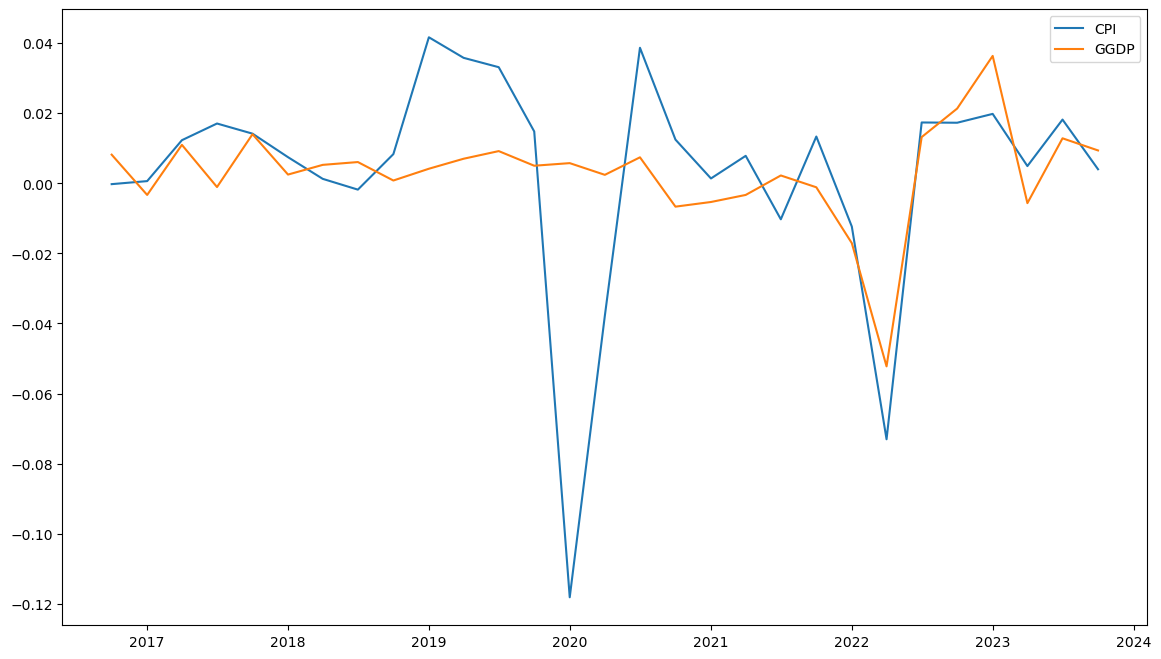

In [425]:
plt.figure(figsize=(14, 8))
plt.plot(endog)
plt.plot(almon_dl_predicts)
plt.legend(('CPI', 'GGDP'))
None

In [226]:
from statsmodels.tsa.api import ARDL
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ardl import ardl_select_order

In [280]:
ardl = ardl_select_order(
    endog, 5, pd.DataFrame(exog), 5, ic="aic", trend="ct"
)
print(f"The optimal order is: {ardl.model.ardl_order}")
ardl_model = ardl.model.fit()
print(ardl_model.summary())

The optimal order is: (4, 2)
                              ARDL Model Results                              
Dep. Variable:             GGDP_RB_SA   No. Observations:                   29
Model:                     ARDL(4, 2)   Log Likelihood                  56.680
Method:               Conditional MLE   S.D. of innovations              0.025
Date:                Thu, 16 May 2024   AIC                            -93.359
Time:                        21:09:40   BIC                            -81.171
Sample:                    10-01-2017   HQIC                           -89.979
                         - 10-01-2023                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0260      0.019      1.357      0.194      -0.015       0.067
trend            -0.0007      0.001     -0.794      0.439      -0.003       0.001
GGDP_RB_SA.

In [281]:
predicts = ardl_model.predict(exog=pd.DataFrame(exog))

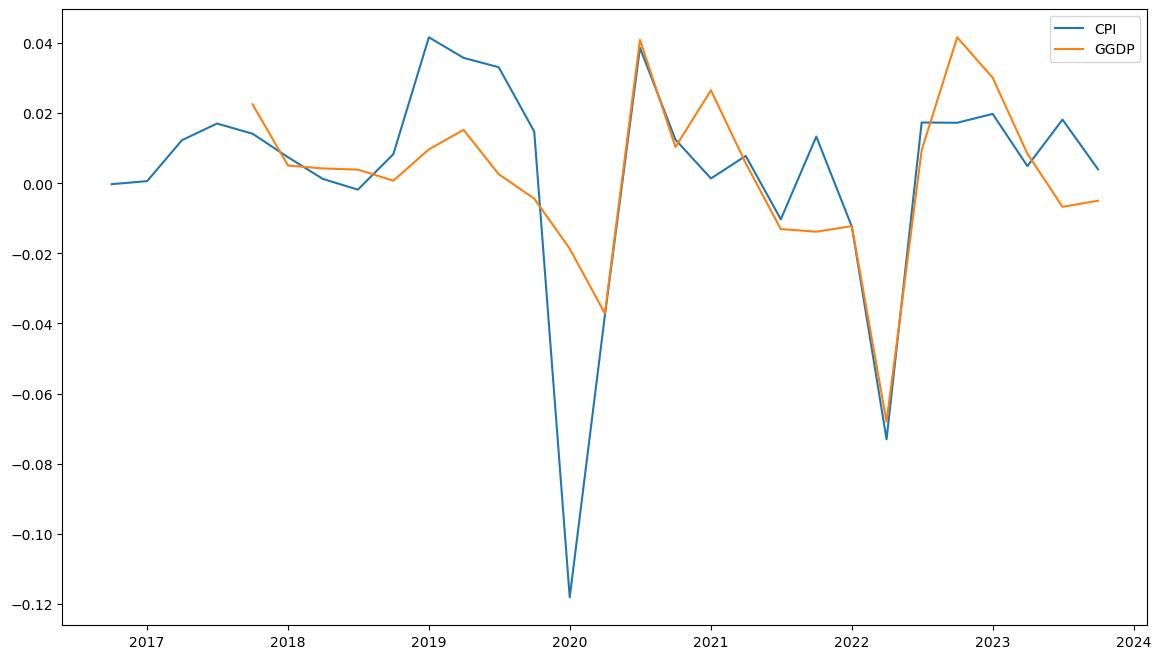

In [283]:
plt.figure(figsize=(14, 8))
plt.plot(endog)
plt.plot(predicts)
plt.legend(('CPI', 'GGDP'))
None

In [220]:
endog.shape

(29,)